# Learning the Keras functional API 

<a id = 'top'></a>

  * A. [Intro to Functional API](#introToFunctionalKeras) 
  * B. [A word about word embeddings](#wordAboutEmbeddings)
  * C. [Description of our dataset](#datasetDescription) 
  * D. [Let's Build our functional model](#buildModel)
  * E. [Let's Train and Evaluate our model](#trainModel)
  * F. [Considerations for further exploration](#furtherExploration)

<a id = 'introToFunctionalKeras'></a>
## A. Intro to Functional API
The Keras functional syntax for models is only slightly different from the sequential syntax.  It is an intuitive way to build up model graphs.  In return it offers much greater flexibility, allowing multiple connections from arbitrary layers to other layers.  

It is referred to as "functional" since you use layers as functions called on input nodes to create output nodes.  A good place to start is the [Keras functional documentation](https://keras.io/guides/functional_api/)

Many of the more advanced deep-learning networks you will learn about require layer connections which are not strictly sequential; therefore we will mostly use the functional syntax moving forward.

This notebook gives you a sense of how to use the functional syntax to create a network, even though our example model will end up being one where layers are consecutively connected.

[Go to Top](#top)

In [1]:
#VERY IMPORTANT - the gensim code here requires gensim==4.0.1.
#make sure you pip install that version of the code.  This will be updated in the future.
!pip install gensim==4.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 14.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-4.0.1-cp39-cp39-linux_x86_64.whl size=23895974 sha256=43bcc23651de56c53c304252bd52307ec8b978180989ad5d913a3a6f45d527a6
  Stored in directory: /home/mhbutler/.cache/pip/wheels/20/74/75/72ec1172891bdecb4ee73fbc2c71d5a150f165b1d0c2ea04e1
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [2]:
import nltk
from nltk.corpus import reuters
from nltk.data import find

#VERY IMPORTANT - the gensim code here requires gensim==4.0.1.
#make sure you pip install that version of the code.  This will be updated in the future.
import gensim

import numpy as np

/home/mhbutler/anaconda3/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


<a id = 'wordAboutEmbeddings'></a>
## B. A word about word embeddings

This example will use pre-trained word embeddings from [nltk / gensim](https://github.com/nltk/nltk/blob/develop/nltk/test/gensim.doctest) 

You will have more chance to work with embedding vectors in a later homework.  If you haven't been exposed to word embeddings (like "word2vec") think of embeddings as a way to represent word meaning in geometric space, allowing us to do things like compare word similarities using vector operations like dot products.  For now, we'll use the word2vec pre-trained model to create an embedding layer for our classifier model.

[Go to Top](#top)

In [3]:
# Download NLTK's sample word2vec embeddings

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

embmod = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)
print('The length of gensim embedding vocabulary : {}'.format(len(embmod)))
EMBEDDING_DIM = len(embmod['university'])
print('Length d of embedding vectors : {}'.format(EMBEDDING_DIM))

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(embmod) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(embmod.key_to_index.keys()):
    embedding_vector = embmod[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

print('The shape of our embedding matrix is {}'.format(embedding_matrix.shape))

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /home/mhbutler/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


The length of gensim embedding vocabulary : 43981
Length d of embedding vectors : 300
The shape of our embedding matrix is (43982, 300)


<a id = 'datasetDescription'></a>
## C. Description of our dataset

We will create a classifier model on the [large movie review dataset from Stanford AI Lab](https://ai.stanford.edu/~amaas/data/sentiment/). 

This dataset was used in the paper:  
[Learning Word Vectors for Sentiment Analysis by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, Christopher Potts from the Jun 2011 issue of ACL.](https://www.aclweb.org/anthology/P11-1015.pdf)  

The dataset training samples are split between:
  * "negative" movie reviews, with ratings in the range (1,2,3,4) and 
  * "positive reviews in the range of (7,8,9,10).
 
We will re-group the ratings into 2 "negative" groups and 2 "positive" groups, to make our classification task a bit easier.

[Go to Top](#top)

In [4]:
# Download the dataset
import requests
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
r = requests.get(url, allow_redirects=True)
print('Finished downloading file')
open('aclImdb_v1.tar.gz', 'wb').write(r.content)

# Untar the downloaded file
!tar xfz aclImdb_v1.tar.gz
print('Finished untar-ing file')

input_length = 100
import os
import re
pos_directory = "./aclImdb/train/pos/"
neg_directory = "./aclImdb/train/neg/"

# The original labels are negative in [1,2,3,4] and 'positive in [7,8,9,10]'
# To simplify our classification let's reduce the number of classes by remapping ratings:
#     Map labels to new labels
#      1, 2  map to 0
#      3, 4 map to 1
#      7, 8  map to 2
#      9, 10 map to 3
maplabels = {"1" : 0, "2" : 0, 
             "3" : 1, "4" : 1,
             "7" : 2, "8" : 2,
             "9" : 3, "10" : 3}

# Create pos and neg training samples by tokenizing the first 100 words from each review
pos_samples = []
pos_labels = []

pat = re.compile('\d+_(\d+).txt')
for file in os.listdir(pos_directory):
    with open(pos_directory + file, 'r') as fh:
        review = fh.readline().split()
        if len(review) < input_length:
            whole = int(input_length / len(review) )
            leftover = len(review) % input_length
            review = review * whole + review[:leftover]
        tokens = [vocab_dict.get(word, 43981) for word in review[:input_length]] # only take the first input_length words
        pos_samples.append(tokens)
        label = pat.sub(r'\1', file) # Extract label from filename
        pos_labels.append(maplabels[label])
        
neg_samples = []
neg_labels = []
for file in os.listdir(neg_directory):
    with open(neg_directory + file, 'r') as fh:
        review = fh.readline().split()
        if len(review) < input_length:
            whole = int(input_length / len(review) )
            leftover = len(review) % input_length
            review = review * whole + review[:leftover]
        tokens = [vocab_dict.get(word, 43981) for word in review[:input_length]]
        neg_samples.append(tokens)
        label = pat.sub(r'\1', file) # Extract label from filename
        neg_labels.append(maplabels[label])
        
# Create x samples and labels
from sklearn.model_selection import train_test_split

xsamples = pos_samples + neg_samples # combine lists
# labels = [1] * len(pos_samples) + [0] * len(neg_samples)
labels = pos_labels + neg_labels

# Repackage as numpy arrays
xsamples = np.array(xsamples)
labels = np.array(labels).reshape([-1,1]) # Labels must have at least one column

# Create training, eval split
train_input, test_input, train_labels, test_labels = train_test_split(xsamples, labels, test_size = 0.2, 
                                                         random_state = 41,
                                                         shuffle = True)

# Investigate the unique class "levels"
print('Our unique class labels are: {}'.format(np.unique(labels)))


Finished downloading file
Finished untar-ing file
Our unique class labels are: [0 1 2 3]


In [5]:
train_input[0]

array([12139, 27101, 14193,  2700, 12139,  7841,  1331, 14193, 43981,
       43981, 33741,  3175, 27692, 22793, 42591,  2326, 12917, 43981,
        4724, 19334, 43981, 40307, 16030, 42958, 17489, 43981, 43981,
       43981, 20526, 22793, 32492, 16915,  3162, 43981, 12917, 43981,
       12292, 34315, 20526, 43981, 38177, 43981, 43981, 25268, 43981,
         333, 12139, 22332, 43981,  8092, 43981, 29538, 42382, 15402,
       31109, 43981, 19123, 23498, 31405, 39566, 43981, 32467,  7046,
       34511,  9722, 15656, 43981, 43981, 43981,  2731, 18232, 40913,
       43981, 43981, 37939, 12917,  4881, 16915, 43981, 19123, 10616,
       16908,  5457,  3824, 43981, 40859, 16915, 14193, 17050, 43981,
       42934, 38725, 43981, 17129, 43981, 34365, 43981,  1959, 36633,
        1100])

In [6]:
# Let's look for possible class imbalance
ltrain = len(train_labels)
print('Number of training samples = {}'.format(ltrain))
for i in range(4):
    nclass = len(np.where(train_labels.reshape([-1]) == i)[0])
    print('class ' + str(i) + ' has {} samples ({:.2f}%)'.format(nclass, 100 * float(nclass / ltrain )))

print()
ltest = len(test_labels)
print('Number of test samples = {}'.format(ltest))
for i in range(4):
    nclass = len(np.where(test_labels.reshape([-1]) == i)[0])
    print('class ' + str(i) + ' has {} samples ({:.2f}%)'.format(nclass, 100 * float(nclass / ltest )))

Number of training samples = 20000
class 0 has 5899 samples (29.49%)
class 1 has 4095 samples (20.47%)
class 2 has 4382 samples (21.91%)
class 3 has 5624 samples (28.12%)

Number of test samples = 5000
class 0 has 1485 samples (29.70%)
class 1 has 1021 samples (20.42%)
class 2 has 1123 samples (22.46%)
class 3 has 1371 samples (27.42%)


<a id = 'buildModel'></a>
## D. Let's build our functional model
Building up a graph involves using layers as functions and calling those functions on input tensors to create output tensors, which then can be used to feed other layers.

For example, you can create an input and output connection using a dense layer by doing the following:

  * x = Dense(50, activation='relu')(x)

or by declaring the layer separately and calling that layer as a function with input, x:

  * dlayer = Dense(50, activation='relu')  
  * x = dlayer(x)

In the second representation, you can see that layer instances resemble functions called on graph nodes.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

#  Package our word2vec embedding model as a fixed pre-trained embedding.
#  Note we set the argument "trainable" to False as we don't want to modify our pre-trained
#  ...embedding values during model training.

embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            # input_length=input_length,
                            trainable=False)

# Note that "trainable" is set to False, since we want our classifier model to leave embedding vectors alone during training.

Now that we've created our first embedding layer, let's build the model adding other layers using the **Functional API**: 

In [8]:
# Choose a word length to truncate each movie review
input_length = 100

# Define an input using our input fixed number of words per review sample
input_x = Input(shape = (input_length,), name="input_words")

# Apply embeddings to each word input
x1 = embedding_layer(input_x) 

# Use Keras lambda function layer to take the mean of the 100 word vectors
x2 = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))(x1)    # average of embedding vectors

# Continue building the network graph                                
x3 = Dense(50, activation='relu', name="hidden1")(x2)   # hidden layer
x4 = Dense(20, activation='relu', name="hidden2")(x3)   # hidden layer

# Our final output classifier layer.  It has 4 outputs (one for each class)
# Because this is a multi-class output we'll use softmax as an activation.
# We want the predictor outputs to always sum to 1 to represent probability.
yhat = Dense(4, activation='softmax', name="output")(x4)   # classification layer

# Define the model
model = Model(inputs=input_x, outputs=yhat, name="keras_func_model")

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])

2022-05-09 22:08:43.059332: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Review the output layers, output dimensions, number of weights**

Let's see whether our dimension discussion was correct. Print a model summary:

In [9]:
model.summary()

Model: "keras_func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 50)                15050     
                                                                 
 hidden2 (Dense)             (None, 20)                1020      
                                                                 
 output (Dense)              (None, 4)                 84        
                                                                 
Total params: 13,210,754
Trainable params: 16,154


<a id = 'trainModel'></a>
## E. Let's Train and Evaluate our model

[Return to Top](#top)

In [10]:
# Train the model
history = model.fit(train_input, train_labels, batch_size = 400, validation_split=0.2, epochs = 50)

Epoch 1/50
40/40 [==============================] - 4s 93ms/step - loss: 1.3740 - sparse_categorical_accuracy: 0.2959 - val_loss: 1.3649 - val_sparse_categorical_accuracy: 0.3235
Epoch 2/50
40/40 [==============================] - 3s 76ms/step - loss: 1.3528 - sparse_categorical_accuracy: 0.3717 - val_loss: 1.3392 - val_sparse_categorical_accuracy: 0.3907
Epoch 3/50
40/40 [==============================] - 4s 99ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.4047 - val_loss: 1.3011 - val_sparse_categorical_accuracy: 0.4080
Epoch 4/50
40/40 [==============================] - 4s 94ms/step - loss: 1.2752 - sparse_categorical_accuracy: 0.4285 - val_loss: 1.2536 - val_sparse_categorical_accuracy: 0.4300
Epoch 5/50
40/40 [==============================] - 4s 92ms/step - loss: 1.2310 - sparse_categorical_accuracy: 0.4442 - val_loss: 1.2151 - val_sparse_categorical_accuracy: 0.4430
Epoch 6/50
40/40 [==============================] - 3s 88ms/step - loss: 1.1973 - sparse_categorical_accu

40/40 [==============================] - 3s 76ms/step - loss: 1.0521 - sparse_categorical_accuracy: 0.5337 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.5192
Epoch 47/50
40/40 [==============================] - 3s 77ms/step - loss: 1.0495 - sparse_categorical_accuracy: 0.5356 - val_loss: 1.0827 - val_sparse_categorical_accuracy: 0.5160
Epoch 48/50
40/40 [==============================] - 4s 99ms/step - loss: 1.0491 - sparse_categorical_accuracy: 0.5359 - val_loss: 1.0834 - val_sparse_categorical_accuracy: 0.5167
Epoch 49/50
40/40 [==============================] - 4s 99ms/step - loss: 1.0483 - sparse_categorical_accuracy: 0.5352 - val_loss: 1.0771 - val_sparse_categorical_accuracy: 0.5192
Epoch 50/50
40/40 [==============================] - 3s 87ms/step - loss: 1.0470 - sparse_categorical_accuracy: 0.5367 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.5232


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


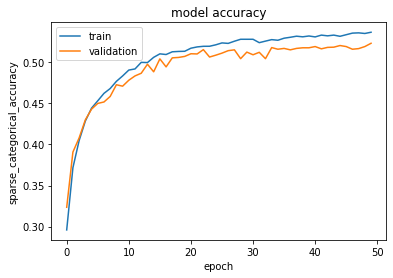

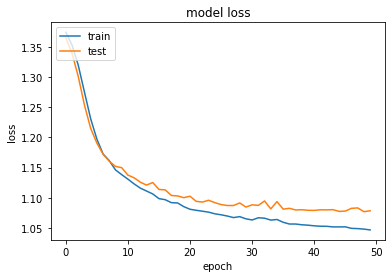

In [11]:
# Plot accuracy and loss for training / validation samples
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<a id = 'furtherExploration'></a>
## F. Some considerations for further exploration are:
1. What evidence do you see that the above model might be over-fitting?

2. Might BOW have some basic limitations for classification accuracy?  You'll explore this more in a homework on a BOW classifier.

3. How might class imbalance impact possible accuracy / bias a model in a particular way to impact accuracy?  How could this be overcome?

4. We are sparse_crossentropy_loss as loss function.  This might not be the optimal loss function.  Can you think of why?